In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import regression_funs as rfu
import funs as fu
import geopandas

import matplotlib.gridspec as gridspec

from sklearn.linear_model import ElasticNetCV

import cartopy.crs as ccrs


## constants and functions

In [2]:

# PATH_TO_FILE = '../data_in/flexpart-mosaic-data_alias/AIRTRACER_100m.nc'

# PATH_TO_SO2 = '../data_in/flexpart-mosaic-data_alias/MSAQSO2L4_2005-2018_v01-04_20190314.h5'

# PATH_TO_ST = '../data_in/ciapitof_masked_filtered.csv'

# PATH_TO_BC = '../data_in/black_carbon_channel6_masked_5min.csv'
# PATH_TO_BC = '../data_in/black_carbon_channel6_raw_5min.csv'


PATH_TO_ST = '../data_in/ciapitof_masked_filtered.csv'

PATH_TO_CO = '../data_in/co_conc_1min.csv'
PATH_200_CLUS = '../data_out/cluster1000.nc'

OUT_FILE = '../data_out2/20_clus_CO_sources_inverse.csv'
OUT_DS_FILE = '../data_out2/DS_20__CO_sources_inverse.nc'
OUT_CONTRS_FILE = '../data_out2/CONTRS_20__CO_sources_inverse.csv'

OUT_MEAS_FILE = '../data_out2/MEAS_20__CO_sources_inverse.csv'



LA = 'lat'
LO = 'lon'
AT = 'AIRTRACER'
L = 'lab'

SA = 'sa'
MSA = 'msa'
IA = 'ia'

BC = 'bc_masked_ngm3'
# BC = 'bc_raw_ngm3'

LBC = 'log(bc)'

LSA = 'log10(sa)'
LMSA = 'log10(msa)'
LIA = 'log10(ia)'

DATA_OUT = '../data_out'

In [3]:
CO = 'conc_masked'
PAR = CO
#

# open and plot PAR timeseries

In [4]:
def _get_df():
    df = pd.read_csv(PATH_TO_CO, index_col=0, parse_dates=True)
    zeros = df[CO] > 0
    print('zeros vs non zeros')
    print(zeros.value_counts())
    df = df[zeros]
    return df

df = _get_df()

zeros vs non zeros
True     406831
False      2450
Name: conc_masked, dtype: int64


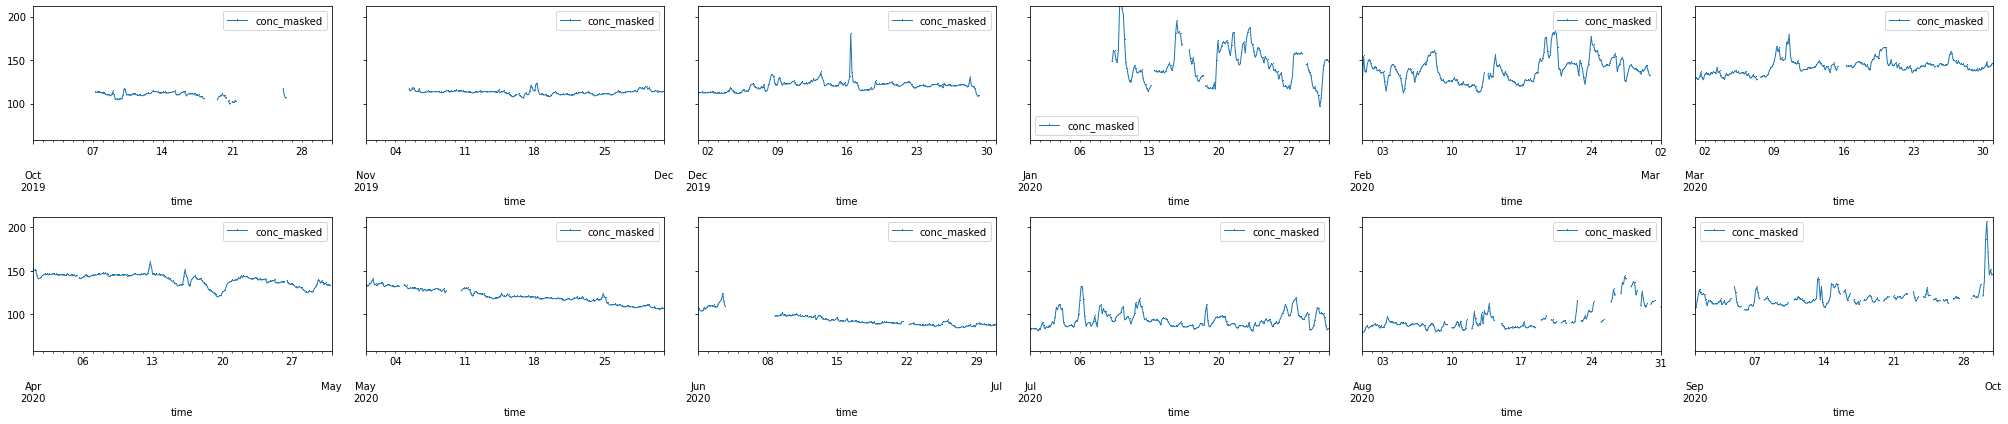

In [5]:
def plt_1(df,ax=None):
    if ax is None:
        f, ax = plt.subplots(figsize=(10, 5))
    df[[PAR]].resample('3H').mean().plot(ax=ax, marker=',', lw=1)
    
def mplt(df):
    qm,qM = df[PAR].quantile([0,.999])
    f,axs = plt.subplots(2,6,sharey=True,figsize=(28,6))
    axf =axs.flatten()
    mm = df.index.min()
    mM = df.index.max()

    ms = [m.strftime('%Y-%m') for m in pd.date_range(mm, mM, freq='M')]
    for i,m in enumerate(ms):
        plt_1(df.loc[m],ax=axf[i])
        ax = axf[i]
        m_ = pd.to_datetime(m)+pd.Timedelta(30,'D')
#         print(m_)
        ax.set_xlim(pd.to_datetime(m), m_)
        ax.set_ylim(qm,qM)
#         ax.set_yscale('symlog',linthresh=1e5,linscale=.1)
#         ax.set_yticks([0,*[a*10**5 for a in range(1,10)],1e5,1e6,1e7])
    f.tight_layout()
    
mplt(df)

In [6]:
df1 = df.resample('3H').mean()[CO]

In [7]:
df2b = df1.rolling(8*30*2,center=True,min_periods=8).median()

<AxesSubplot:xlabel='time'>

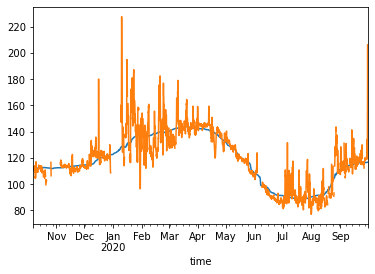

In [8]:
df2b.plot()
df1.plot()

In [9]:
df3 = (df1-df2b+10)

<AxesSubplot:xlabel='time'>

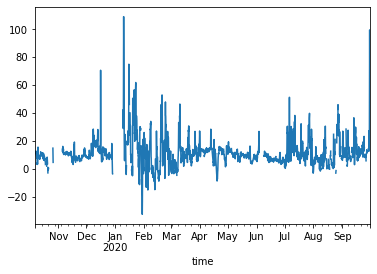

In [10]:
df3.plot()

In [11]:
df = df3.to_frame()
# df = df['2020-01':'2020-02']

(0.0, 116.06121678218709)

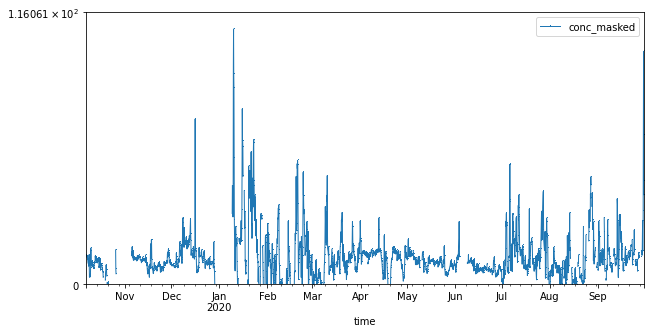

In [12]:
plt_1(df)
plt.gca().set_yscale('symlog',linthresh=1e5,linscale=.1)
plt.gca().set_ylim(0,None)

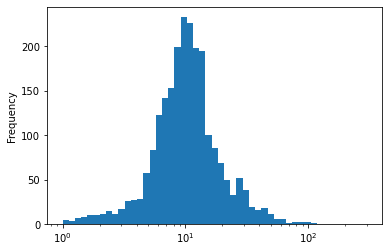

In [13]:
def _plt_dist(df):
    df[PAR].plot.hist(bins=np.geomspace(1, .3e3))
    plt.gca().set_xscale('log')
_plt_dist(df)

# open and merge flex 200 ro 1000 clusters

In [14]:
ds = xr.open_dataset(PATH_200_CLUS)

In [15]:
def _merge_ds_and_df(ds,df):
    dsf = ds.groupby(L).sum().to_dataframe()[AT].unstack(L)

    df1 = df

    df2 = df1.resample('3H').median()

    dm = pd.merge(df2, dsf, left_index=True, right_index=True, how='inner', validate="1:1")
    return dm,dsf 
dm,dsf = _merge_ds_and_df(ds,df)

# 1st CV Inverse modeling elastic NET

0.0016955114462302828 0.1


/Users/aliaga/Documents/Work_DA/Py-packs/flexpart-mosaic/nbV2/regression_funs.py:102: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(q0, q1)
/Users/aliaga/Documents/Work_DA/Py-packs/flexpart-mosaic/nbV2/regression_funs.py:103: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(q0, q1)
/Users/aliaga/Documents/Work_DA/Py-packs/flexpart-mosaic/nbV2/regression_funs.py:118: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(q0, q1)


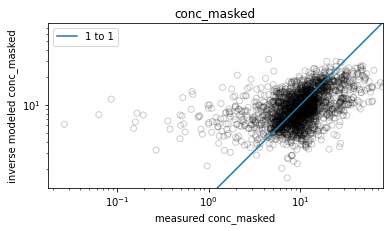

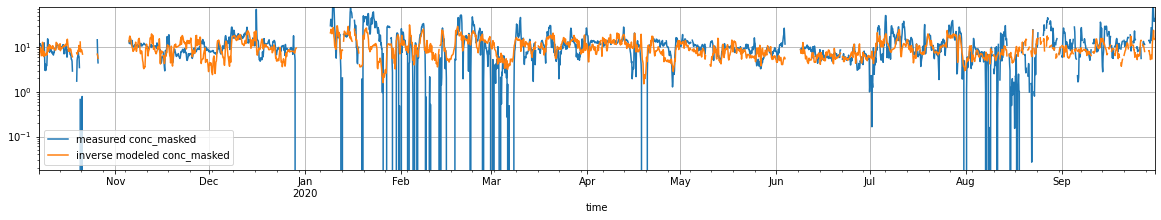

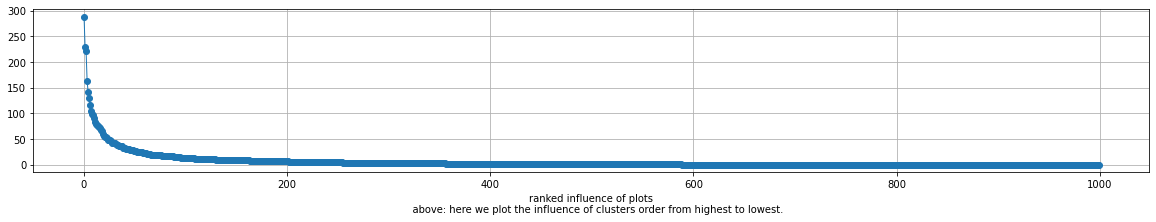

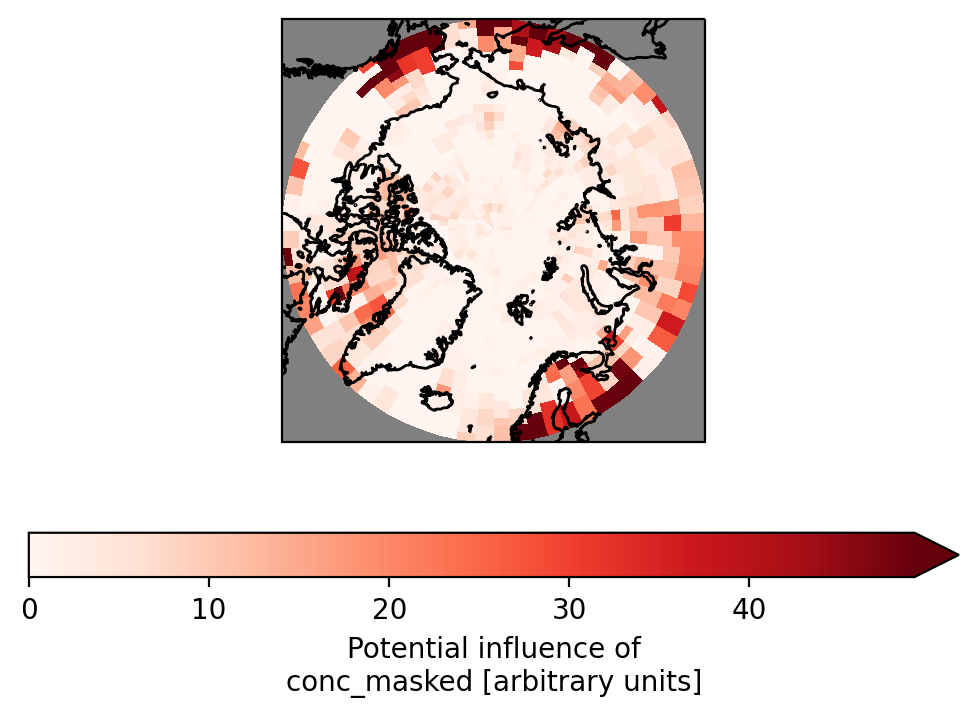

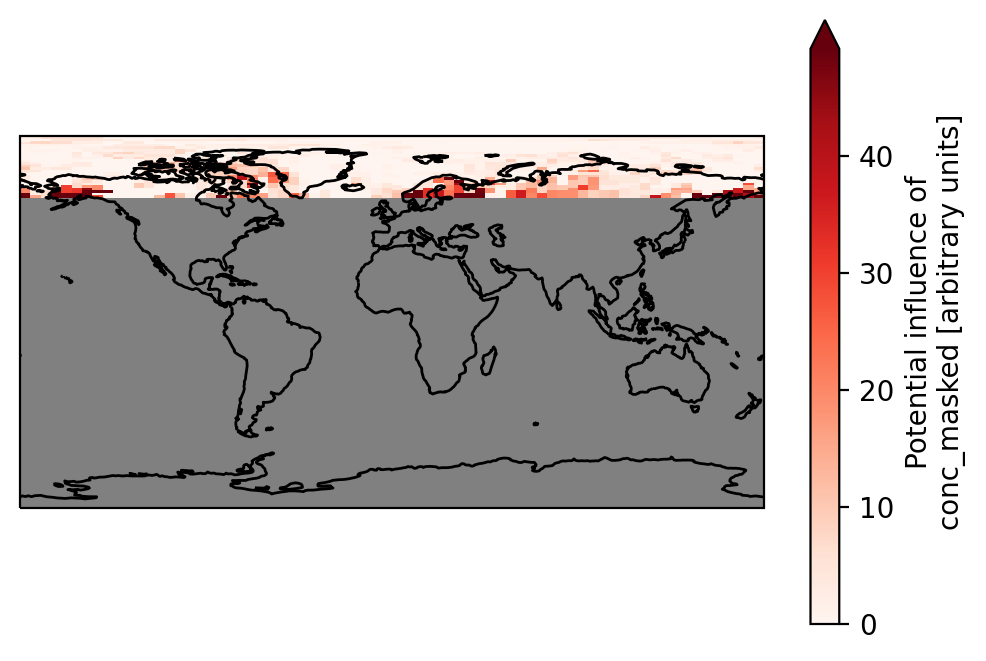

In [16]:
# for PAR in [SA,MSA,IA]:
def plt_el_net(dsf,dm):
    pred, cdf, y, yn, dp, regr = rfu.elastic_net_reg2(dsf, dm, PAR)
    MEA = f'measured {PAR}'
    MOD = f'inverse modeled {PAR}'
    rfu.scatter_plot(y, yn, pred, MEA, MOD, PAR)
    rfu.mea_vs_mod_plot(y, yn, dp, pred, MEA, MOD)
    rfu.rank_cluster_inf(cdf)
    dd2 = rfu.get_plot_inf(cdf, L, ds, PAR)
    rfu.plot_map(dd2)
    rfu.plot_map_rect(dd2)
    return regr

    
regr = plt_el_net(dsf,dm)

In [17]:
pred, cdf, y, yn, dp, regr = rfu.elastic_net_reg2(dsf, dm, PAR)

0.0016955114462302828 0.1


In [18]:
def get_rat(dp,y,yn):
    from sklearn.linear_model import LinearRegression

    lr = LinearRegression(fit_intercept=True).fit(dp[yn].to_frame(),y[yn])
    
    r2 = lr.score(dp[yn].to_frame(),y[yn])
    coef = lr.coef_.item()
    inte = lr.intercept_

    return r2,coef, inte
r2, rat,inte = get_rat(dp,y,yn)
rat, r2,inte

(1.2049014568328857, 0.28782876726666884, -0.77795887)

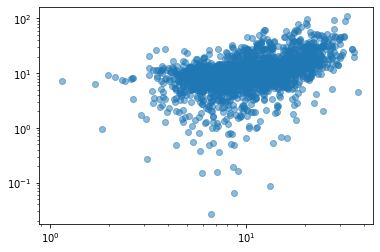

In [19]:
plt.scatter(dp[yn]*rat+inte,y[yn],alpha=.5)
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')

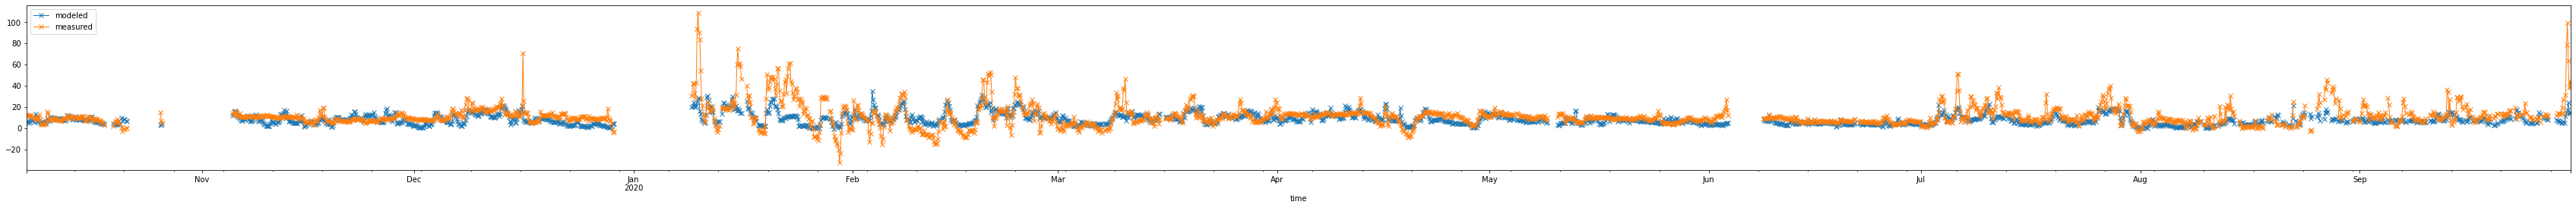

In [20]:
def _plot(rat,dm,dsf,cdf,y):
    AA = rat #should be 1 
    _ = (dm[dsf.columns] * (cdf*rat+inte))
    __ = _.sum(axis=1)[yn].resample('3H').mean()
    __.plot(lw=1,marker='x', label = 'modeled')
    plt.gcf().set_figwidth(60)
#     plt.gca().set_yscale('symlog',linthresh=1e5,linscale=.1)
#     plt.gca().set_ylim(0,None)
    y[yn].resample('3H').mean().plot(lw=1,marker='x', label = 'measured')
    plt.gca().legend()

_plot(rat,dm,dsf,cdf,y)

In [21]:
def get_contr(rat,dm,dsf,cdf,A,yn,inte):
    _cdf = cdf>0
#     AA = rat #should be 1
    _ = (dm[dsf.columns] * (cdf * rat+inte))[yn].T.where(_cdf).T
    __ = _.sum(axis=0)
    a =  __.sort_values()[::-1].cumsum()/__.sum()
    __ = __.where(a<A,0)
    return __

contr =  get_contr(rat,dm,dsf,cdf,1,yn,inte)

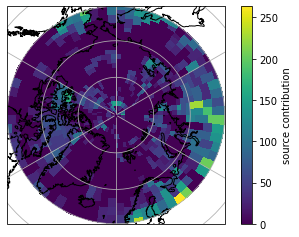

In [22]:
def _plt(ds,contr,ax=None):
    import matplotlib as mpl
    # pred, cdf, y, yn, dp, regr = rfu.elastic_net_reg2(dsf, dm, PAR)

    _1 = ds['lab'].to_dataframe()['lab'].iloc[:, 1].replace(contr.to_dict()).to_xarray()
    _1.name = 'source contribution'

    if ax is None:
        _, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Orthographic(0, 90)))
    ax.coastlines()
    ax.gridlines()
    _1.plot(ax=ax, transform=ccrs.PlateCarree(),vmin=0)


_plt(ds,contr)

In [23]:
N=14

def _clus(dm,dsf,cdf,contr,ds,yn,rat,inte, N ):
#     N = 20

    from sklearn.cluster import KMeans

    contrs_ = (dm[dsf.columns] * (cdf*rat + inte)).T.where(contr > 0, 0).T[yn]

    _norm = np.sqrt((contrs_ ** 2).sum())

    _nn = contrs_ / _norm
    _nn1 = _nn.dropna(axis=1)

    km = KMeans(N, random_state=123)

    _l = km.fit_predict(_nn1.T.values) + 1

    _l1 = pd.Series(_l, index=_nn1.T.index)
    _nl = (_norm * 0 + _l1)

    def _reorder_by_inf(_nl, contrs_):
        i_ = contrs_.T.groupby(_nl).sum().T.sum().sort_values()[::-1].reset_index()['index']
        i_.index = i_.index + 1
        _order = {v: i for i, v in i_.items()}
        _nl = _nl.replace(_order)
        return _nl

    _nl = _reorder_by_inf(_nl, contrs_)

    d_ = ds['lab'].to_series().replace(_nl.to_dict()).to_xarray()
    d_.name = 'sorted_inf_clusters'
    return d_, contrs_, _nl


(
    ds['sorted_inf_clusters'],
    contrs,
    nl
) = _clus(dm,dsf,cdf,contr,ds,yn,rat,inte,N)





In [24]:
a = regr.alpha_
l = regr.l1_ratio_

In [25]:
a,l

(0.0016955114462302828, 0.1)

In [26]:
def _plot_clust_infs(contrs,nl,dsf,cdf,y, rat,dm,inte,yn,N):
    AA = 1
    clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()
    for i in range(1, N+1):
        (AA*clus_ts[i]).plot(c=plt.get_cmap('tab20')(i - 1),lw=5)
    plt.gcf().set_figwidth(60)
    plt.gca().legend()
    #plt.gca().set_yscale('symlog')

    #(contrs.T.groupby(nl).sum().sum()*rat).plot(c='.7', ls='--', marker='D')

    def plt_model(dm):
        _ = dm[dsf.columns] * (cdf * rat + inte)
        __ = _.sum(axis=1)
        __[yn].resample('3H').mean().plot(lw=1, marker='+', label='modeled', alpha=.5, c='k')

    plt_model(dm)

    y[yn].resample('3H').mean().plot(lw=1, marker='o', label='measured', c='k', mfc='none', alpha=.5)

    plt.legend()
    ymin, ymax = y[yn].quantile([0,.999])
#     plt.gca().set_ylim(ymin,ymax)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_33364/2105437306.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


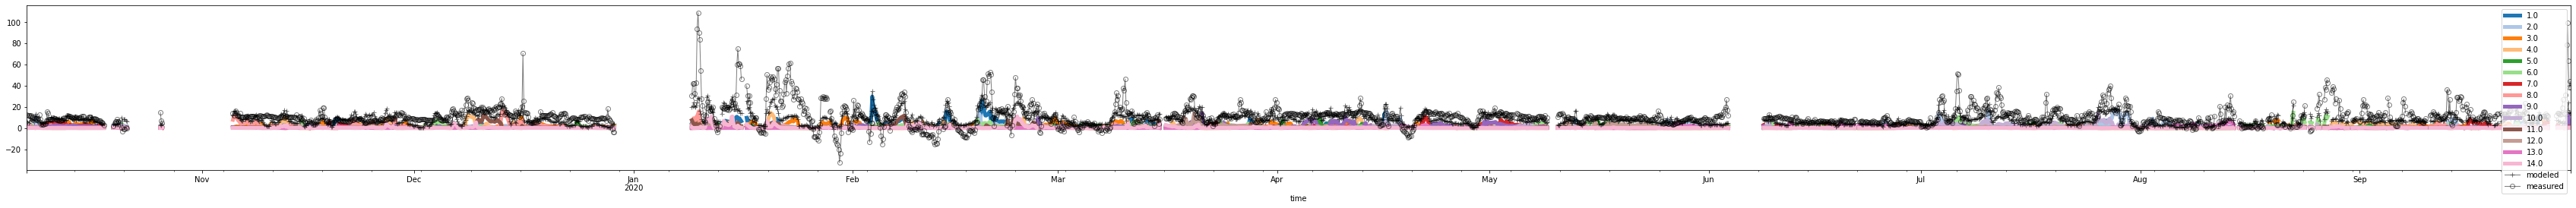

In [27]:
_plot_clust_infs(contrs,nl,dsf,cdf,y, rat, dm,inte,yn,N)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_33364/2587168831.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


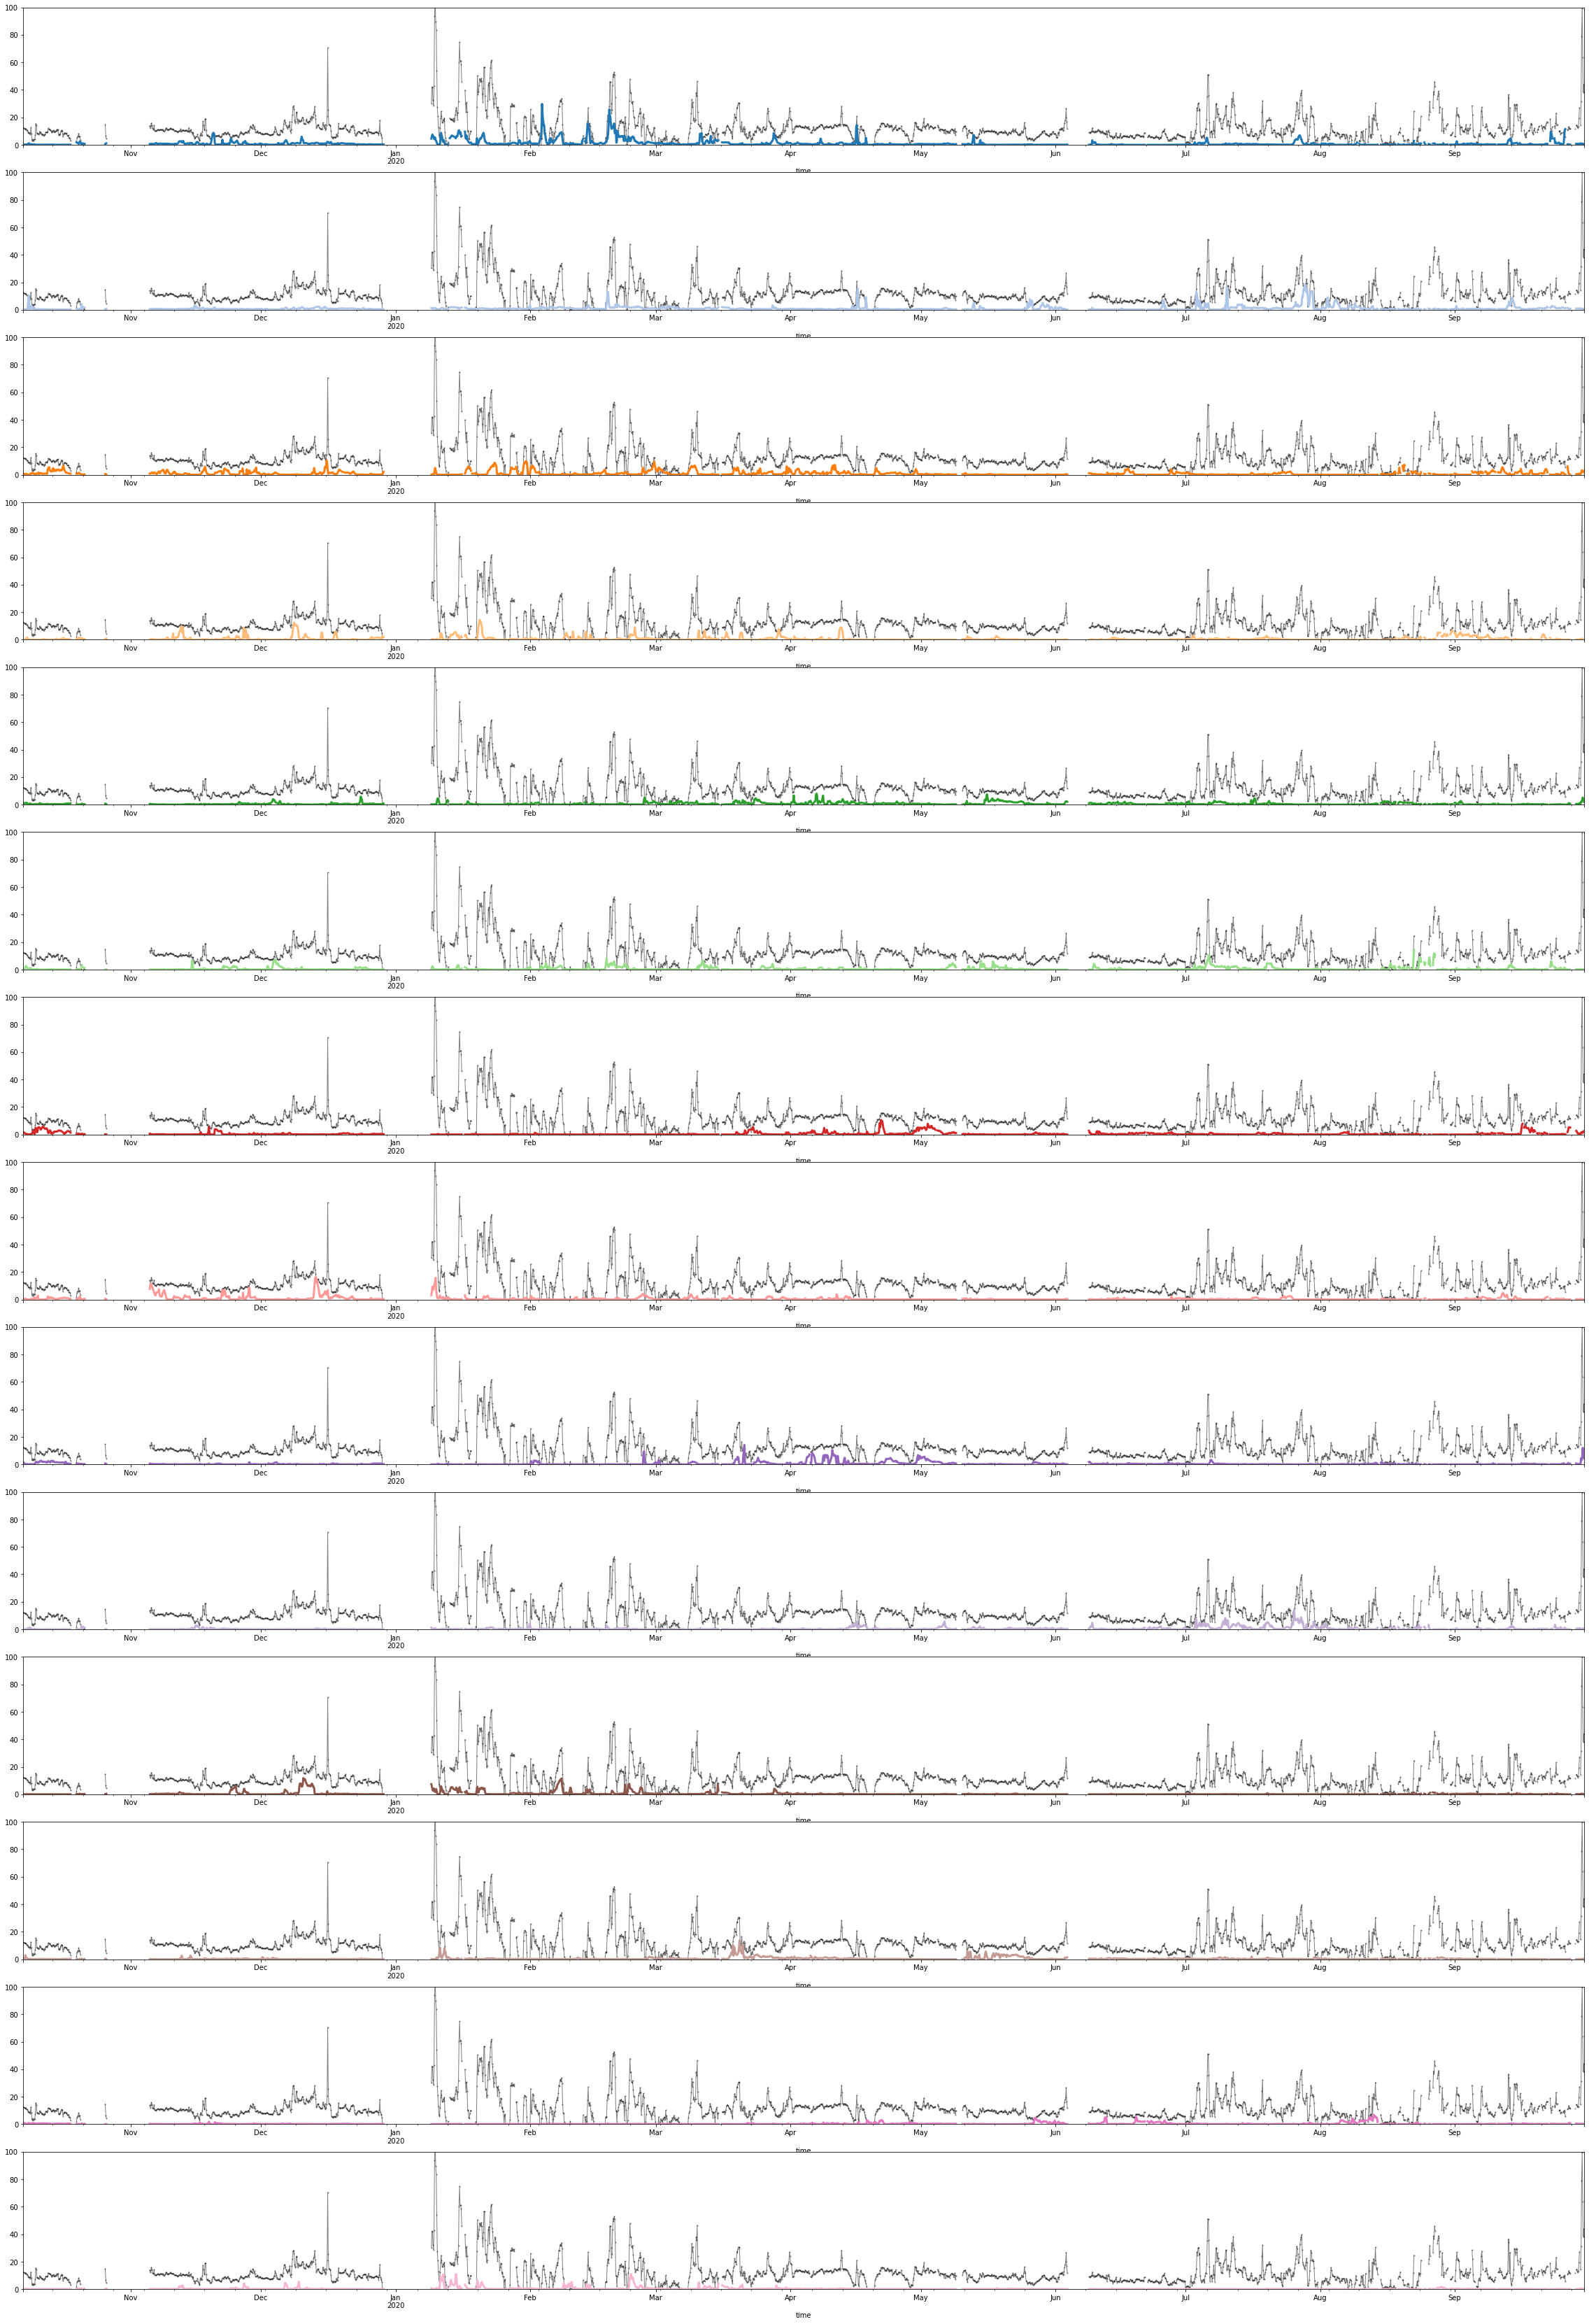

In [28]:
def plot_single_contrs(contrs, nl, yn,y, N):
    clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()
    f, axs = plt.subplots(N, 1, figsize=(40, 3 * 20), sharey=True)
    axf = axs.flatten()
    for i in range(1, N+1):
        y[yn].resample('3H').mean().plot(lw=1, marker='o', label='measured', c='k', mfc='none', alpha=.5, ax=axf[i - 1],
                                         ms=1)
        clus_ts[i].plot(ax=axf[i - 1], c=plt.get_cmap('tab20')(i - 1), lw=3)
        axf[i - 1].set_ylim(0, 100)

plot_single_contrs(contrs, nl, yn,y, N)

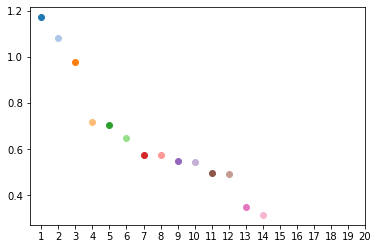

In [29]:
def plt_contrs(contrs,nl,N):
    d = contrs.T.groupby(nl).sum().T.mean()
    for i in range(0,N):
        plt.scatter(d.index[i],d.iloc[i],c=[plt.get_cmap('tab20')(i)])
    plt.gca().set_xticks(range(1,21));
plt_contrs(contrs,nl,N)

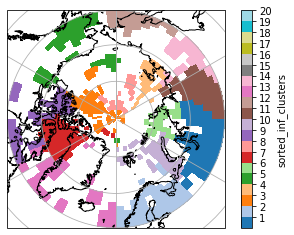

In [30]:
def _plt_influence_clusters(ds):
    import matplotlib as mpl
    _,ax = plt.subplots(subplot_kw=dict(projection=ccrs.Orthographic(0, 90)))
    ax.coastlines()
    ax.gridlines()
    (ds['sorted_inf_clusters']-.5).plot(ax=ax,transform=ccrs.PlateCarree(),cmap='tab20',
                                        cbar_kwargs={'ticks':range(1,21)},
                                        vmin=0,vmax=20)
_plt_influence_clusters(ds)

# multi elastic net

In [31]:
l

0.1

In [32]:
aa = np.geomspace(a/100,a*200,36)
CC = 17

LL = .5

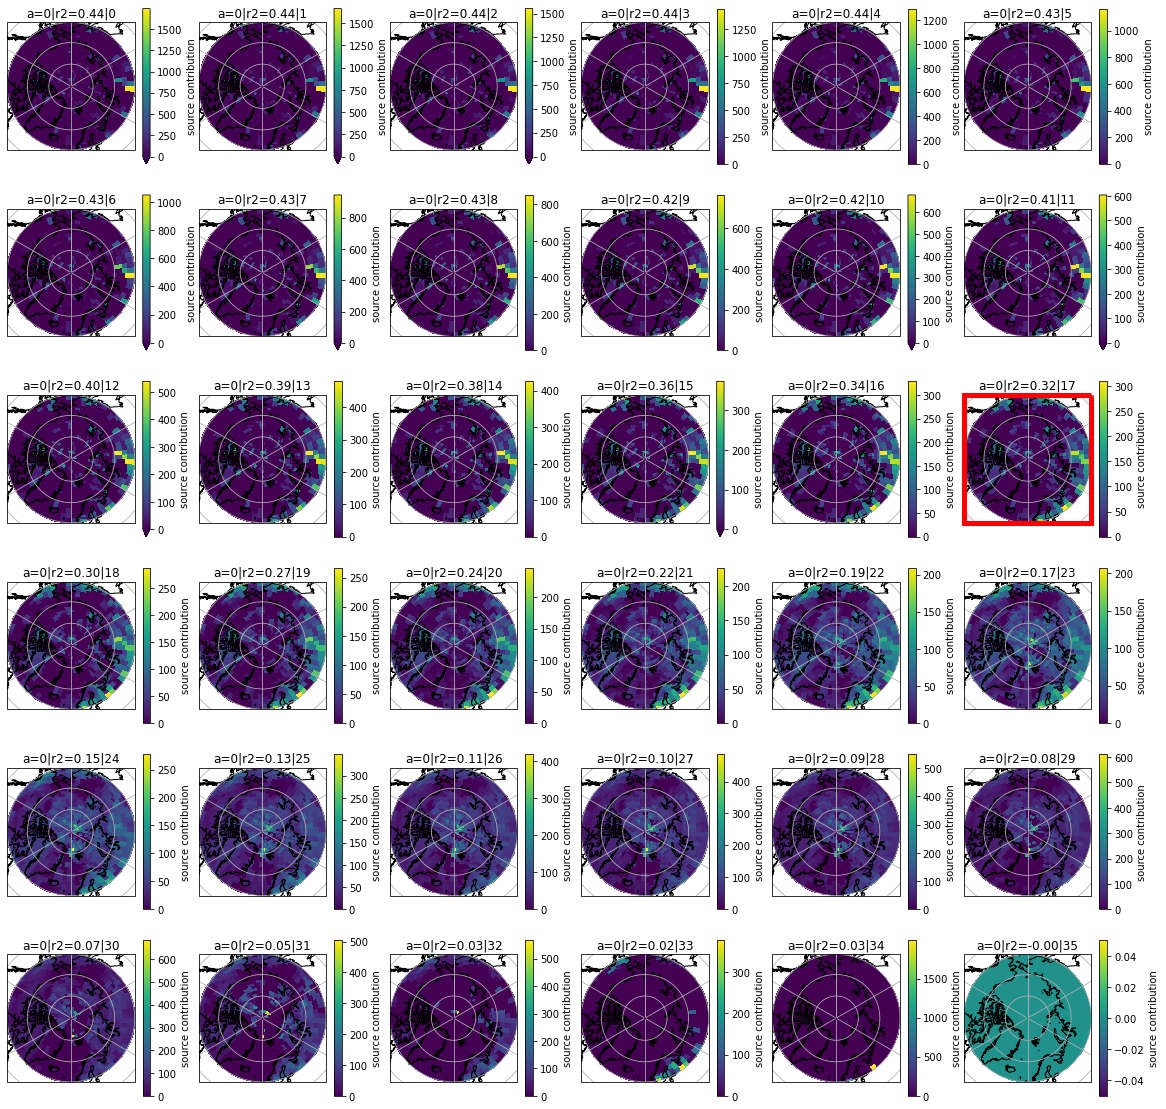

In [33]:
def elastic_net_reg3(dsf, dm, PAR, a, l ):
    from sklearn.linear_model import ElasticNet

    c200 = dsf.columns

    X = dm[c200]

    ### normalize X
    xn = np.sqrt(  (X ** 2).sum()  ) ** (1/1)
    XX = X.divide(xn, axis=1)
    #############


    _y = dm[PAR]
    yn = _y.notna()
    y = _y[yn]
    regr = ElasticNet(a,l1_ratio=l, random_state=123, positive=True, fit_intercept=False)

    regr.fit(XX[yn], y[yn])

#     print(regr.alpha_,regr.l1_ratio_)

    pred = regr.predict(XX[yn])
    dp = pd.Series(pred, index=y[yn].index)
    _cdf = pd.Series(regr.coef_, index=XX.columns)
    cdf = _cdf / xn
    return pred, cdf, y, yn, dp, regr

def _multi_plot(aa,CC):
    
    f,axs = plt.subplots(6,6,figsize=(20,20),subplot_kw=dict(projection=ccrs.Orthographic(0, 90)))
    axf = axs.flatten()
    
    for i_,a_ in enumerate(aa):
        ax = axf[i_]
        pred, cdf, y, yn, dp, regr = elastic_net_reg3(dsf, dm, PAR,a_,LL)
        r2, rat, inte = get_rat(dp,y,yn)
        contr = get_contr(rat,dm,dsf,cdf,1,yn,inte)
        _plt(ds,contr,ax)
        ax.set_title(f'a={a_:.0f}|r2={r2:.2f}|{i_}')
        if i_ == CC:
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(5)
_multi_plot(aa,CC)

# chosen elastic net

In [34]:
pred, cdf, y, yn, dp, regr = elastic_net_reg3(dsf, dm, PAR,aa[CC],LL)
r2, rat, inte = get_rat(dp,y,yn)

In [35]:
LL,aa[CC]

(0.5, 0.002081480938807183)

/Users/aliaga/Documents/Work_DA/Py-packs/flexpart-mosaic/nbV2/regression_funs.py:102: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(q0, q1)
/Users/aliaga/Documents/Work_DA/Py-packs/flexpart-mosaic/nbV2/regression_funs.py:103: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(q0, q1)
/Users/aliaga/Documents/Work_DA/Py-packs/flexpart-mosaic/nbV2/regression_funs.py:118: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(q0, q1)


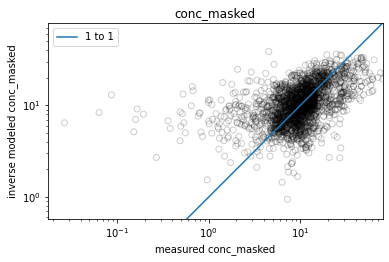

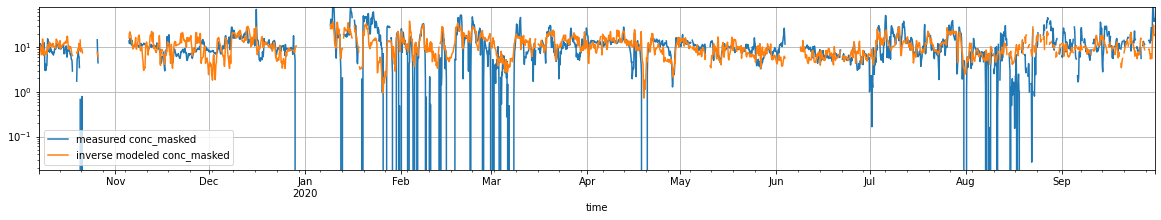

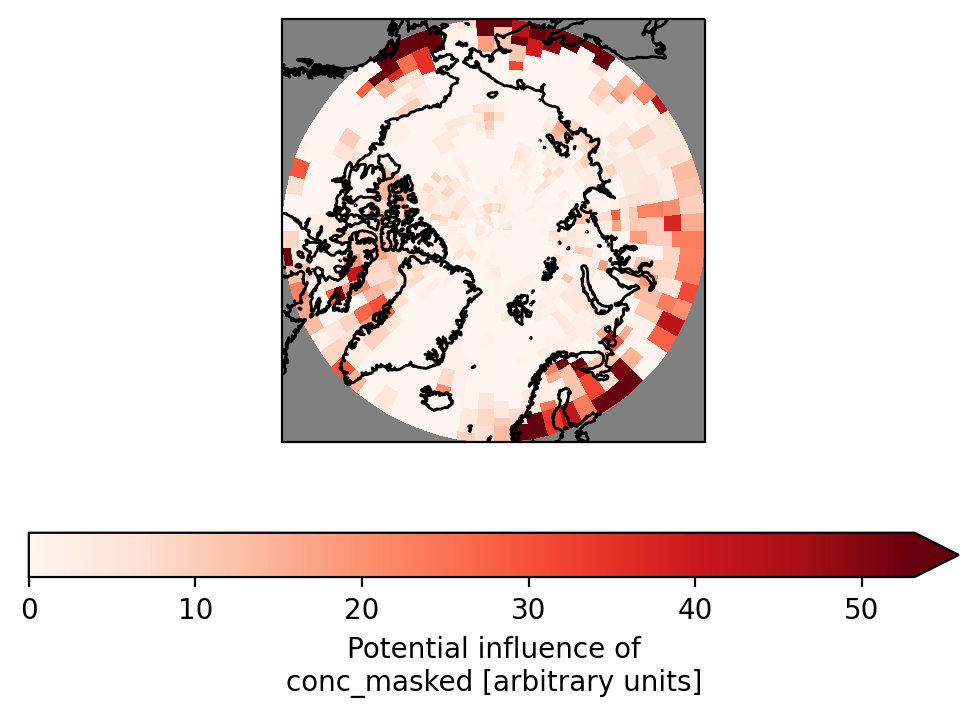

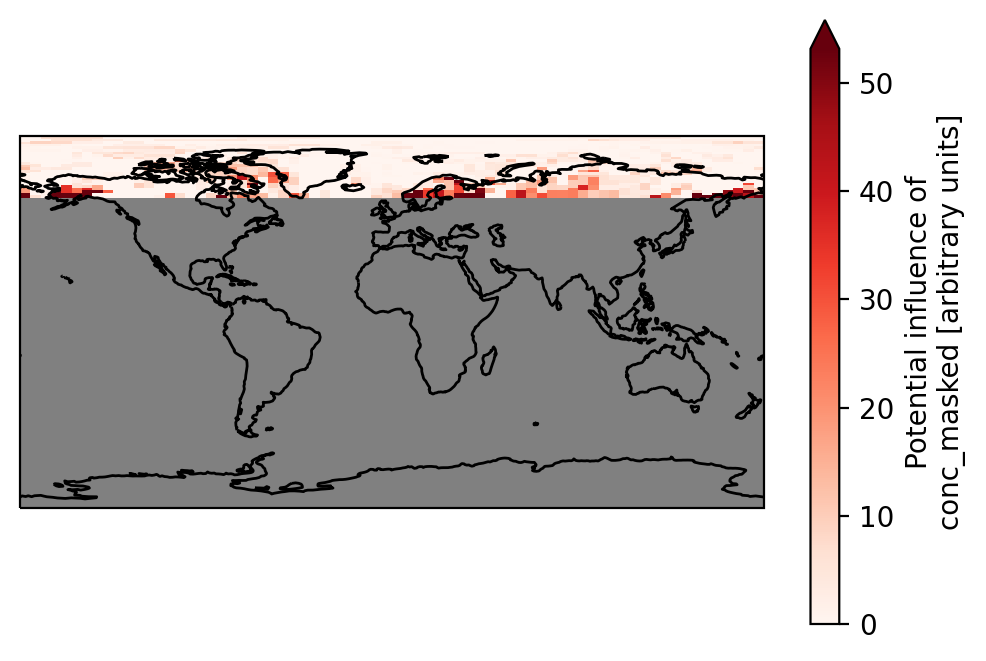

In [36]:
# for PAR in [SA,MSA,IA]:
def plt_el_net():
    
    MEA = f'measured {PAR}'
    MOD = f'inverse modeled {PAR}'
    rfu.scatter_plot(y, yn, pred*rat+inte, MEA, MOD, PAR)
    rfu.mea_vs_mod_plot(y, yn, dp*rat+inte, pred*rat+inte, MEA, MOD)
    #rfu.rank_cluster_inf(cdf)
    dd2 = rfu.get_plot_inf(cdf, L, ds, PAR)
    rfu.plot_map(dd2)
    rfu.plot_map_rect(dd2)
    return regr

    
regr = plt_el_net()

In [37]:
N = 11
contr = get_contr(rat,dm,dsf,cdf,1, yn,inte)

(
    ds['sorted_inf_clusters'],
    contrs,
    nl
) = _clus(dm,dsf,cdf,contr,ds, yn, rat , inte, N)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_33364/2105437306.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


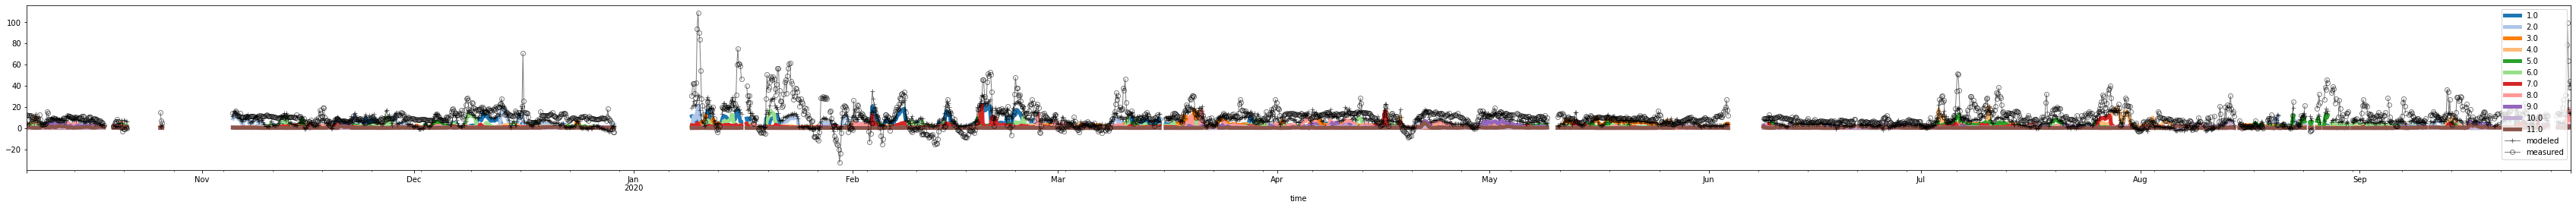

In [38]:
_plot_clust_infs(contrs=contrs,nl=nl,dsf=dsf,cdf=cdf,y=y, rat=rat, dm=dm, inte=inte, yn=yn,N=N)

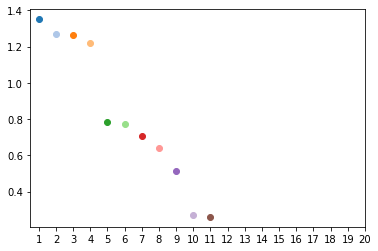

In [39]:
def plt_contrs(contrs,nl,N):
    d = contrs.T.groupby(nl).sum().T.mean()
    for i in range(0,N):
        plt.scatter(d.index[i],d.iloc[i],c=[plt.get_cmap('tab20')(i)])
    plt.gca().set_xticks(range(1,21));
plt_contrs(contrs,nl,N)

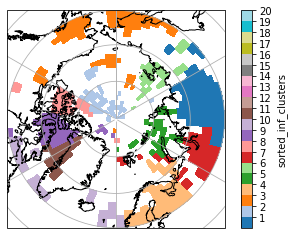

In [40]:
_plt_influence_clusters(ds)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_33364/2587168831.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


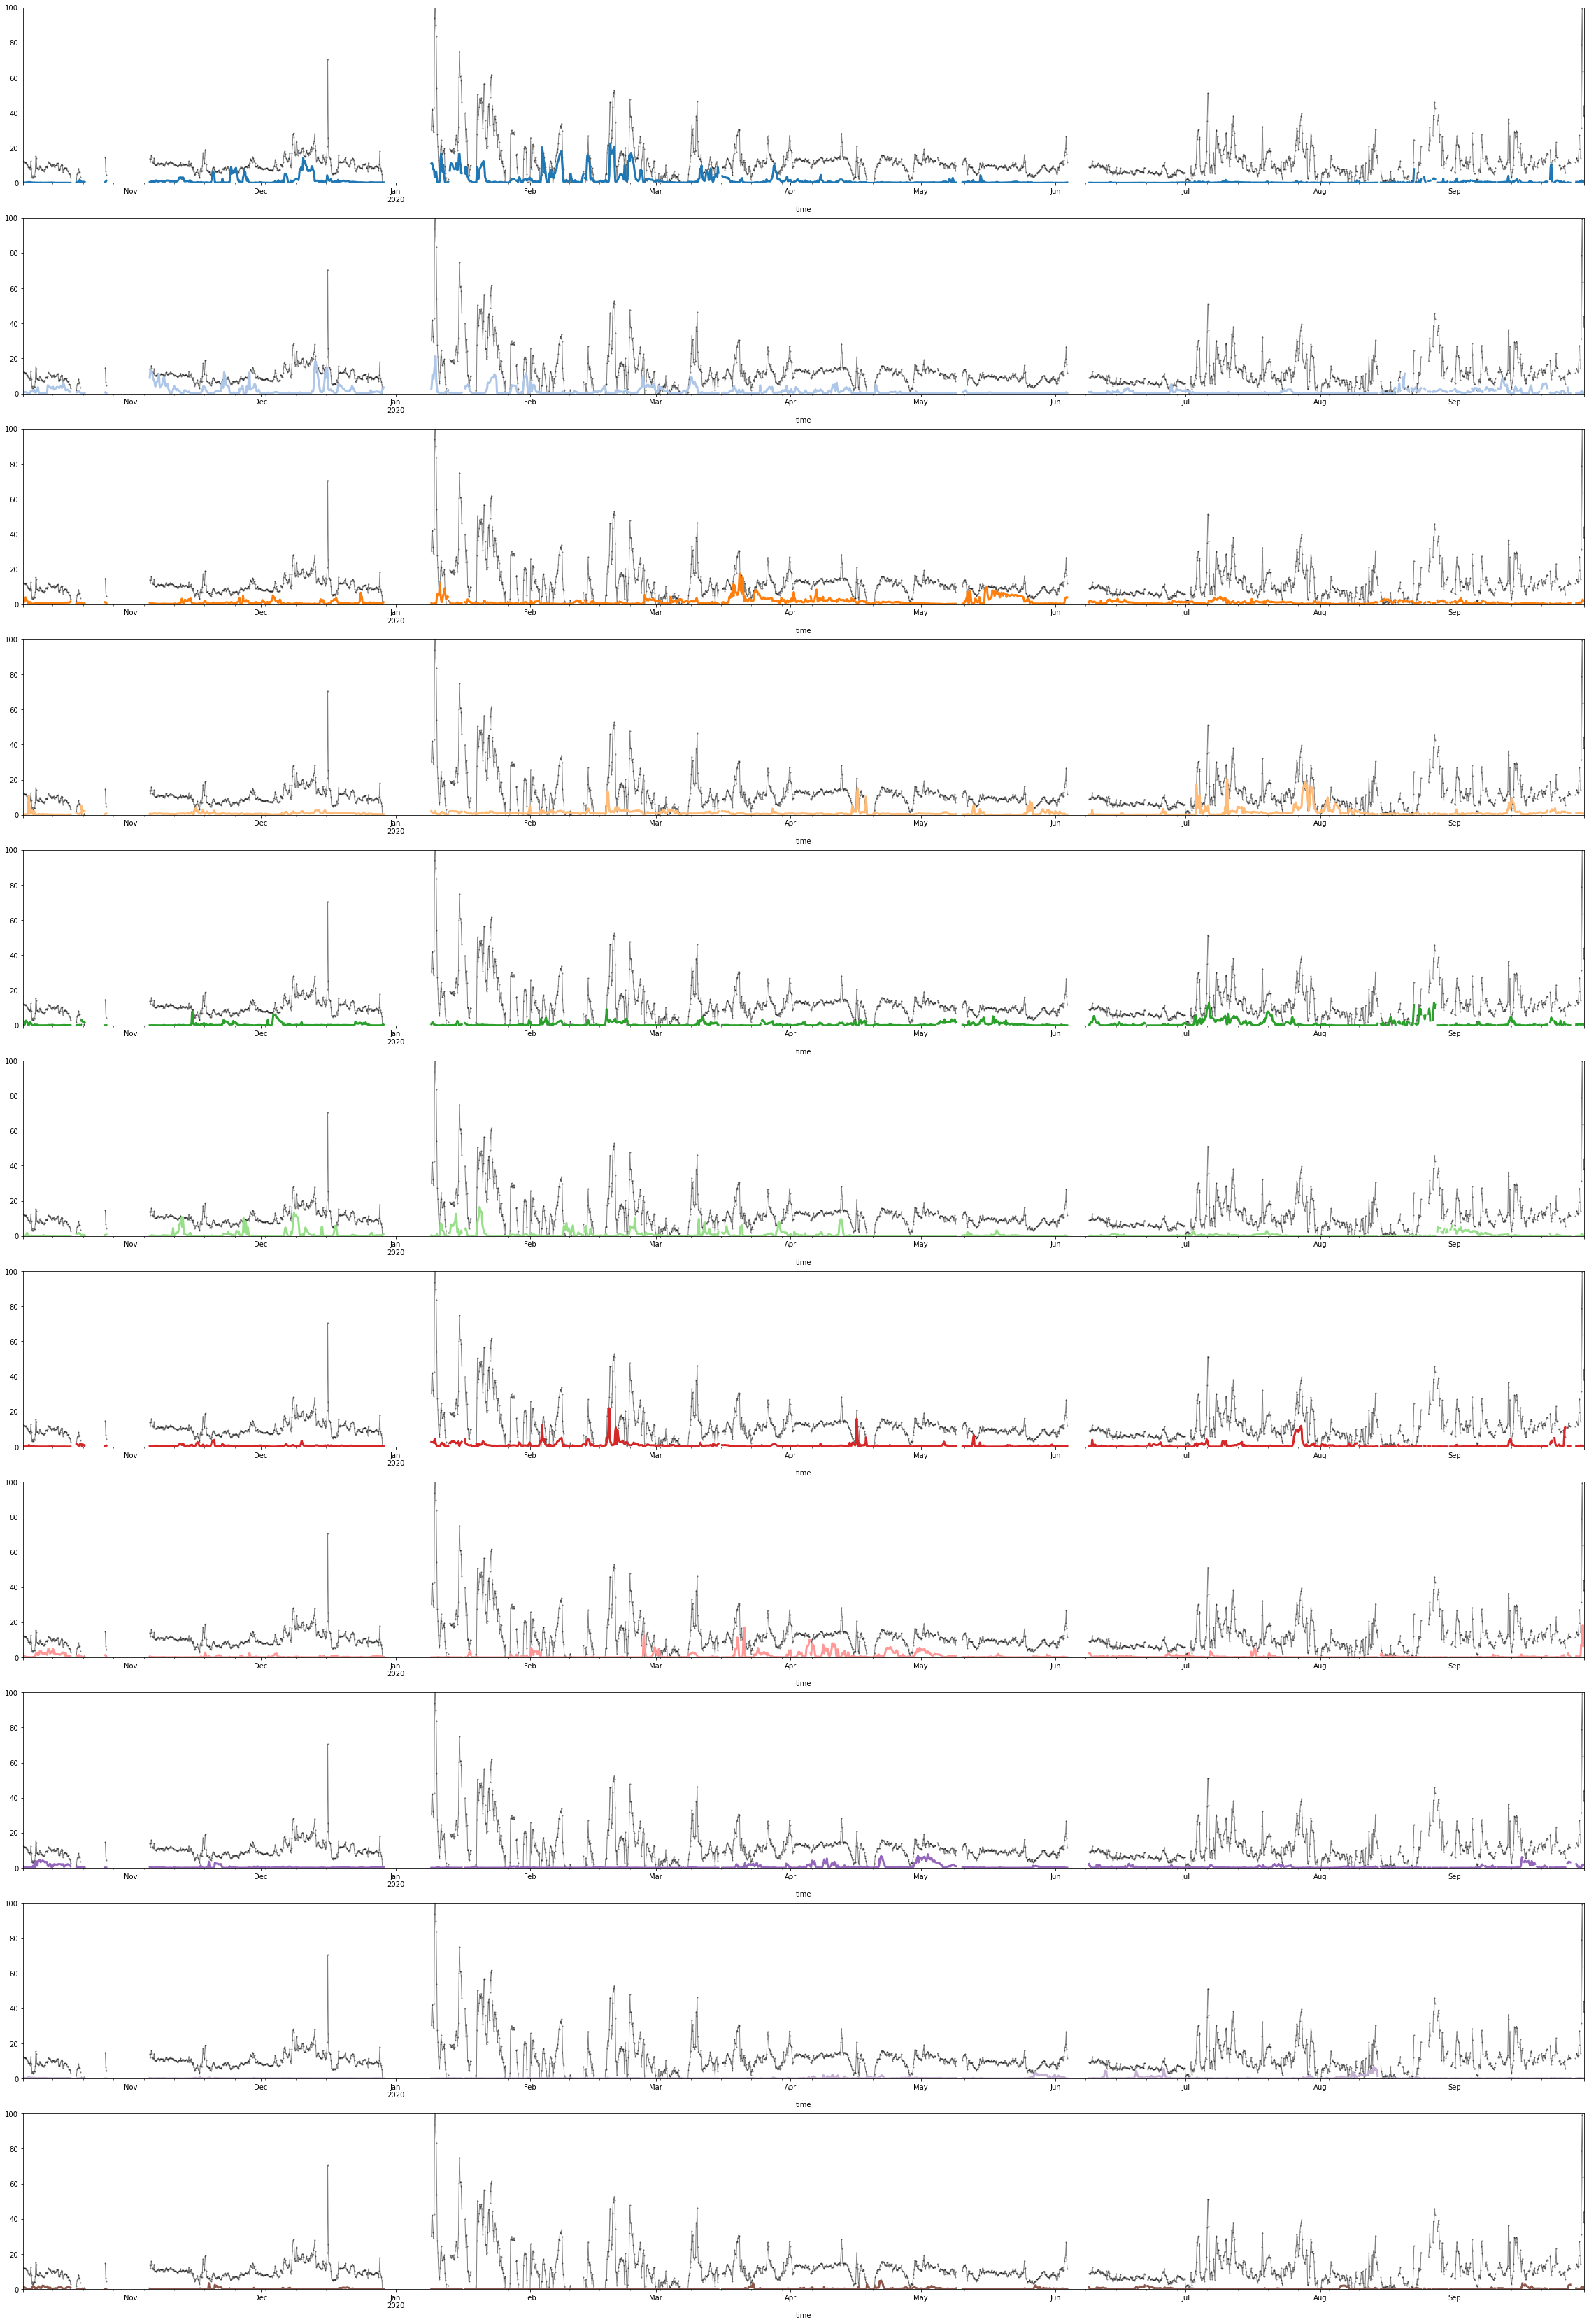

In [41]:
plot_single_contrs(contrs, nl, yn,y,N)

# save data

In [42]:
clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_33364/2478368837.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


In [43]:
clus_ts

1.0       2.0       3.0       4.0       5.0   \
time                                                                    
2019-10-07 06:00:00  0.100858  1.092268  1.601870  0.287650  0.016641   
2019-10-07 09:00:00  0.081496  0.829256  1.240466  0.230442  0.024545   
2019-10-07 12:00:00  0.161712  0.743111  1.349522  0.289603  0.134344   
2019-10-07 15:00:00  0.144558  0.757681  1.977137  0.290176  0.891313   
2019-10-07 18:00:00  0.279847  0.874657  3.926255  0.391905  2.055007   
...                       ...       ...       ...       ...       ...   
2020-09-30 09:00:00  0.898452  1.132638  1.437835  0.962179  0.728305   
2020-09-30 12:00:00  0.733693  0.277417  2.631086  0.741970  0.724761   
2020-09-30 15:00:00  0.707913  0.264490  1.919523  0.755368  0.918504   
2020-09-30 18:00:00  0.598764  0.290615  1.963089  0.738201  0.544264   
2020-09-30 21:00:00  0.867908  0.768837  1.937319  0.742524  0.459048   

                         6.0       7.0        8.0       9.0       10.0  \
time                                                                     
2019-10-07 06:00:00  0.158839  0.052943   1.659767  0.859649  0.286953   
2019-10-07 09:00:00  0.058676  0.045594   1.149144  0.845638  0.372648   
2019-10-07 12:00:00  0.072714  0.096327   0.550228  0.493194  0.324593   
2019-10-07 15:00:00  0.114646  0.078692   0.527437  0.503273  0.312729   
2019-10-07 18:00:00  0.189911  0.161774   0.208709  0.469402  0.271455   
...                       ...       ...        ...       ...       ...   
2020-09-30 09:00:00  0.541973  0.664095   9.379005  1.348179  0.098285   
2020-09-30 12:00:00  0.190159  0.355505  18.242220  1.944132  0.066572   
2020-09-30 15:00:00  0.134975  0.417025   7.278615  1.905227  0.088045   
2020-09-30 18:00:00  0.134321  0.408556   6.968964  1.776361  0.085904   
2020-09-30 21:00:00  0.567399  0.423312   6.517729  1.538113  0.088989   

                         11.0  
time                           
2019-10-07 06:00:00  1.043649  
2019-10-07 09:00:00  1.370101  
2019-10-07 12:00:00  1.000484  
2019-10-07 15:00:00  0.857301  
2019-10-07 18:00:00  0.710505  
...                       ...  
2020-09-30 09:00:00  0.574403  
2020-09-30 12:00:00  0.057469  
2020-09-30 15:00:00  0.816455  
2020-09-30 18:00:00  1.243667  
2020-09-30 21:00:00  0.951796  

[2878 rows x 11 columns]

In [44]:
clus_ts.to_csv(OUT_FILE)

In [45]:
fu.compressed_netcdf_save(ds,OUT_DS_FILE)

In [46]:
contrs.to_csv(OUT_CONTRS_FILE)

In [47]:
yn.to_csv(OUT_MEAS_FILE)